In [1]:
import os

import matplotlib.pyplot as plt

In [2]:
import os
os.chdir('./simulation')

In [3]:
from pymdp import utils
from pymdp.agent import Agent
import numpy as np
import pandas as pd
from env import TrialEnv

In [4]:
trials = 100
steps = 2  # number of timepoints per trial

TATES<br>
state if the img is cs+ or cs-

In [5]:
context = ['cs+', 'cs-']
choice = ['guess cs+','guess cs-']
#error = ['low', 'high']

BSERVATIONS

morphing level binary. shock only if morph_level=6

In [6]:
morph_level_obs = ['0','1']
# the subject receive the electric shock?
shock_obs = ['shock','no_shock','null']
# observation to discriminate if the subject is surprised or prepared. A sort of diff between user prediction and shock observation
surprised_obs = ['not_surprised','surprised','null']

CTIONS<br>
the subject predict if should be receive the shock or not

In [7]:
context_action = ['do_nothing']
choice_action = ['guess cs+','guess cs-']

Define `num_states` and `num_factors` below

In [8]:
num_states = [len(context), len(choice)] #[2,2]
num_factors = len(num_states) #2

efine `num_obs` and `num_modalities` below

In [9]:
num_obs = [len(morph_level_obs), len(shock_obs), len(surprised_obs)] # [2,2,2]
num_modalities = len(num_obs) #3

In [10]:
def matrices():
    """
    The A, B, C, D, E matrices are built.
    """
    # This is the likelihood mapping that truly describes the relationship between the
    # environment's hidden state and the observations the agent will get

    # A matrix
    # A dimension?
    A = utils.obj_array(num_modalities)
    A_morph = np.zeros((len(morph_level_obs), len(context), len(choice)))
    A_shock = np.zeros((len(shock_obs), len(context), len(choice)))
    A_surprise = np.zeros((len(surprised_obs), len(context), len(choice)))
    for j in range(len(choice)):
        # mor_lev_binary/states #cs+ #cs-
        A_morph[:,:,j] = np.array([[0, 1],    #img or
                                   [1, 0]])   #img minac
        #shock-noshock/states
        A_shock[:,:,j] = np.array([[0.75, 0],
                                   [0.25, 1],
                                   [0, 0]])
        #surprise/states
        A_surprise[:,j,j] = np.array([1,0,0])
        A_surprise[:,j,int(not j)] = np.array([0, 1, 0])
    A[0] = A_morph
    A[1] = A_shock
    A[2] = A_surprise

    # B matrix
    # The transition mapping that truly describes the environment's dynamics

    #B as an identity matrix. no state transitions
    B = utils.obj_array(num_factors)
    B_context = np.zeros((len(context), len(context), len(context_action)))
    B_context[:,:,0] = np.eye(len(context))
    #B_context[:,:,2] = np.eye(len(context))
    B_choice = np.zeros((len(choice), len(choice), len(choice_action)))
    for choice_i in range(len(choice)):
        B_choice[choice_i, :, choice_i] = 1.0
    B[0]=B_context
    B[1]=B_choice

    # This is the matrix representing the preferences over outcomes
    #prepared-surprised/cs+-
    C = utils.obj_array_zeros(num_obs)          #num modalities
    C[0] = np.zeros(2)
    C[1] = np.zeros(3)
    C[2] = np.array([2,-3,0])
    return A, B, C

true data


In [11]:
def load_data(columns=[], binary_morphing_level=False, shock_as_int = False,subject_number=0,remove_first_trials=None,remove_last_trials=None):
    '''
    Function that read NewLookAtMe files and extract
    :param columns:
    :param binary_morphing_level:
    :param shock_as_int:
    :param subject_number:
    :return:
    '''

    df = pd.read_csv('../data/newLookAtMe/newLookAtMe01.csv')
    df = df.filter(columns)

    if 'morphing level' in columns and binary_morphing_level:
        df['morphing level'] = [int(d==6) for d in df['morphing level']]
    if 'shock' in columns and shock_as_int:
        df['shock'] = df['shock'].astype(int)
    if remove_first_trials is not None:
        df = df[remove_first_trials:]
        df.reset_index(drop=True,inplace=True)
    return df

In [12]:
data= load_data(columns=['morphing level','shock'] ,binary_morphing_level=True, shock_as_int = True,remove_first_trials=16)

fake data generation

In [13]:
morphing_levels = [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10
shocks = [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10 + [0] * 10 + [1] * 10
fake_data_4_75 = pd.DataFrame({'morphing level': morphing_levels, 'shock': shocks})

# Select rows where both columns are equal to 1
mask = (fake_data_4_75['morphing level'] == 1) & (fake_data_4_75['shock'] == 1)

# Select 25% of those rows at random
sampled_indices = np.random.choice(fake_data_4_75[mask].index, size=int(len(fake_data_4_75[mask]) * 0.4), replace=False)

# Set the values in those rows to (1,0)
fake_data_4_75.loc[sampled_indices, 'shock'] = 0


In [14]:
morphing_levels = [0] * 50 + [1] * 50
shocks = [0] * 50 + [1] * 50
fake_data_half = pd.DataFrame({'morphing level': morphing_levels, 'shock': shocks})

define an agent<br>


In [15]:
E = utils.obj_array(1)
E[0] = np.array([.4,.2,.4])
A,B,C = matrices()
my_agent = Agent(A=A, B=B, C=C, gamma=16)
qs0 = my_agent.qs
# define an environment
my_env = TrialEnv(data=fake_data_4_75)
list_qs = []
list_action = []

In [16]:
initial_action = 'first_action'

iterate over all trials

In [17]:
list_action = []
list_qs = []
for trial in range(trials):

    print("\n-----TRIAL " + str(trial) + " ------")

    agent_stimul_obs, agent_shock_obs, agent_surpr_obs = 'null', 'null', 'null'
    agent_stimul_obs = my_env.get_observation(param='morphing level', trial_number=trial)
    print('observation (t=0): ', agent_stimul_obs, agent_shock_obs, agent_surpr_obs)
    obs = [morph_level_obs.index(agent_stimul_obs), shock_obs.index(agent_shock_obs),
            surprised_obs.index(agent_surpr_obs)]

    qs = my_agent.infer_states(obs)  # agent update beliefs about hidden states given observations
    print('beliefs over states (t=0):', qs[0]*100)
    list_qs.append(qs[0])


    policies = my_agent.infer_policies()  # inferring policies and sampling actions from the posterior
    agent_action = my_agent.sample_action()

    action_name = choice_action[int(agent_action[1])]

    print('beliefs over actions: ', policies[0]*100)
    print('action: ', action_name)
    list_action.append(action_name)

    agent_surpr_obs = my_env.step(action_name, trial)
    agent_shock_obs = my_env.get_observation(param='shock', trial_number=trial)

    print('observation (t=1): ', agent_stimul_obs, agent_shock_obs, agent_surpr_obs)

    obs = [morph_level_obs.index(agent_stimul_obs), shock_obs.index(agent_shock_obs),
           surprised_obs.index(agent_surpr_obs)]
    qs = my_agent.infer_states(obs)  # agent update beliefs about hidden states given observations
    print('beliefs over states (t=1):', qs[0] * 100)
    #my_agent.reset()


-----TRIAL 0 ------
observation (t=0):  0 null null
beliefs over states (t=0): [50. 50.]
beliefs over actions:  [50. 50.]
action:  guess cs+
observation (t=1):  0 no_shock surprised
beliefs over states (t=1): [1.e-14 1.e+02]

-----TRIAL 1 ------
observation (t=0):  0 null null
beliefs over states (t=0): [2.e-14 1.e+02]
beliefs over actions:  [1.80485139e-33 1.00000000e+02]
action:  guess cs-
reward
observation (t=1):  0 no_shock not_surprised
beliefs over states (t=1): [3.e-30 1.e+02]

-----TRIAL 2 ------
observation (t=0):  0 null null
beliefs over states (t=0): [1.e-14 1.e+02]
beliefs over actions:  [1.80485139e-33 1.00000000e+02]
action:  guess cs-
reward
observation (t=1):  0 no_shock not_surprised
beliefs over states (t=1): [2.e-30 1.e+02]

-----TRIAL 3 ------
observation (t=0):  0 null null
beliefs over states (t=0): [1.e-14 1.e+02]
beliefs over actions:  [1.80485139e-33 1.00000000e+02]
action:  guess cs-
reward
observation (t=1):  0 no_shock not_surprised
beliefs over states (t

In [18]:
list_csplus=[]
list_csminus=[]
for index, value in enumerate(list_qs):
    list_csplus.append(value[0])
    list_csminus.append(value[1])
    #print('trial:',(index),'',value[0], '  ',value[1])

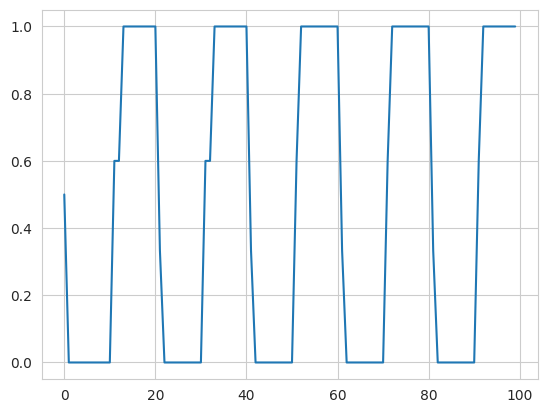

In [19]:
plt.plot(list_csplus)

In [20]:
y=[]
for index, value in enumerate(list_action):
    if value=='guess cs-':
        y.append(0)
    if value=='guess cs+':
        y.append(1)


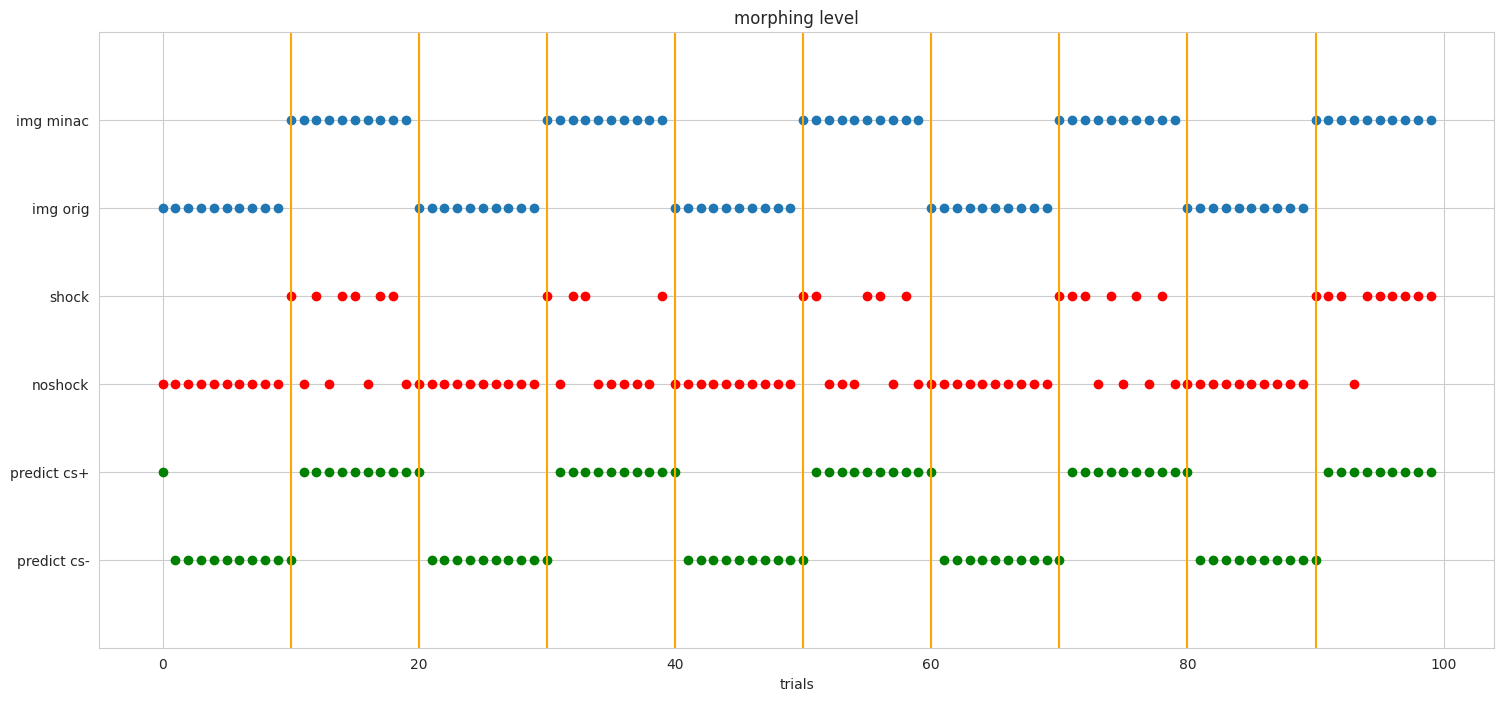

In [21]:
fig = plt.figure(figsize=(18,8))
plt.ylim(-1,6)
plt.yticks(ticks=(0,1,2,3,4,5),labels=('predict cs-','predict cs+','noshock','shock','img orig','img minac'))
plt.xlabel('trials')
plt.title('morphing level')
plt.scatter(np.arange(len(fake_data_4_75['morphing level'])),fake_data_4_75['morphing level']+4)
plt.scatter(np.arange(len(fake_data_4_75['shock'])),fake_data_4_75['shock']+2,color='red')
plt.scatter(np.arange(len(y)),y,color = 'green')
for i in range(1, 10):
    plt.axvline(x=10*i, color='orange')

In [22]:
data_with_vote = data.copy(deep=True)
data_with_vote['action'] = list_action

ValueError: Length of values (100) does not match length of index (144)